In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-12-28 15:05:34.268507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:34.375587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:34.376668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:34.380008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2021-12-28 15:05:36.675742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:36.677201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:36.678485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:36.679930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 15:05:36.681070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3861152236880324259,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16191631892039616457
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# Import Necessary Libraries

In [4]:
import zipfile
import os
with zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip','r') as zip_ref:
    zip_ref.extractall("./sentiment-analysis-on-movie-reviews/")
with zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip','r') as zip_ref:
    zip_ref.extractall("./sentiment-analysis-on-movie-reviews/")

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

pd.options.display.max_colwidth = 500

# Get Rotten Tomatoes Movie Reviews Dataset

Rotten Tomatoes Movie Reviews Dataset is taken from https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.



*   "train.tsv" contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
*   "test.tsv" contains just phrases. You must assign a sentiment label to each phrase.

The sentiment labels are:


*   0: negative
*   1: somewhat negative
*   2: neutral
*   3: somewhat positive
*   4: positive

In [6]:
data = pd.read_table("/kaggle/working/sentiment-analysis-on-movie-reviews/train.tsv",sep='\t')
data = data[['Phrase','Sentiment']].copy()
data

,Phrase,Sentiment
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,A series of escapades demonstrating the adage that what is good for the goose,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


In [7]:
print("0: " + str(len(data[data['Sentiment'] == 0])))
print("1: " + str(len(data[data['Sentiment'] == 1])))
print("2: " + str(len(data[data['Sentiment'] == 2])))
print("3: " + str(len(data[data['Sentiment'] == 3])))
print("4: " + str(len(data[data['Sentiment'] == 4])))

0: 7072
1: 27273
2: 79582
3: 32927
4: 9206


# Data Pre-processing

In [8]:
import re
import spacy

sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words
# stopwords |= {"movie","movies","film","story","character","characters","comedy"}
# print(stopwords)
# stopwords.remove('not')

def remove_stopwords(text):
    text_tokens = text.split(" ")
    text_tokens_filtered= [word for word in text_tokens if not word in all_stopwords]
    return (" ").join(text_tokens_filtered)

def clean(text):
#     text = remove_stopwords(text.lower())        # Removing stopwords decreased accuracies, therefore we did not use!!!
    text = re.sub(r'@|#', r'', text.lower())     # Returns a string with @-symbols and hashtags removed.
    text = re.sub(r'http.*', r'', text.lower())  # Returns a string with any websites starting with 'http.' removed.
    return ' '.join(re.findall(r'\w+', text.lower())) # Returns a string with only English unicode word characters ([a-zA-Z0-9_]).

data['Phrase'] = data['Phrase'].apply(lambda x: clean(x))
data

,Phrase,Sentiment
0,a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story,1
1,a series of escapades demonstrating the adage that what is good for the goose,2
2,a series,2
3,a,2
4,series,2
...,...,...
156055,hearst s,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


Splitting "train.tsv" dataset to Train and Validation.

*   Train Set: %90 (Train: %85 - Val: %15)
*   Test Set: %10

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data.index.values, 
                                                  data.Sentiment.values, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=data.Sentiment)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=y_train)

data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'
data.loc[X_test, 'data_type'] = 'test'

data = data.dropna()

# Remove duplicates 
train_set = data[data['data_type'] == 'train'].drop_duplicates(ignore_index=True)
val_set = data[data['data_type'] == 'val'].drop_duplicates(ignore_index=True)
test_set = data[data['data_type'] == 'test'].drop_duplicates(ignore_index=True)

data = pd.concat([train_set, val_set, test_set], ignore_index=True)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)
data

,Phrase,Sentiment,data_type
0,george w bush henry kissinger,2,train
1,age wise,2,train
2,the potential,2,train
3,practically any like themed film other than its oscar sweeping franchise predecessor,3,train
4,rarely has a film s title served such dire warning,0,val
...,...,...,...
149224,s not exactly worth,1,train
149225,welcome or accept the trials of henry kissinger as faithful portraiture,3,train
149226,rarely seem sure of where it should go,1,train
149227,the dialogue,2,train


<AxesSubplot:xlabel='Sentiment'>

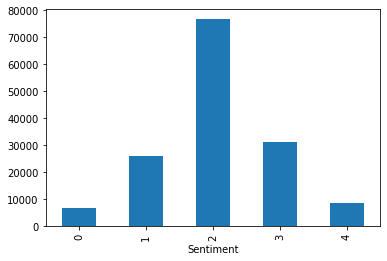

In [10]:
data.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

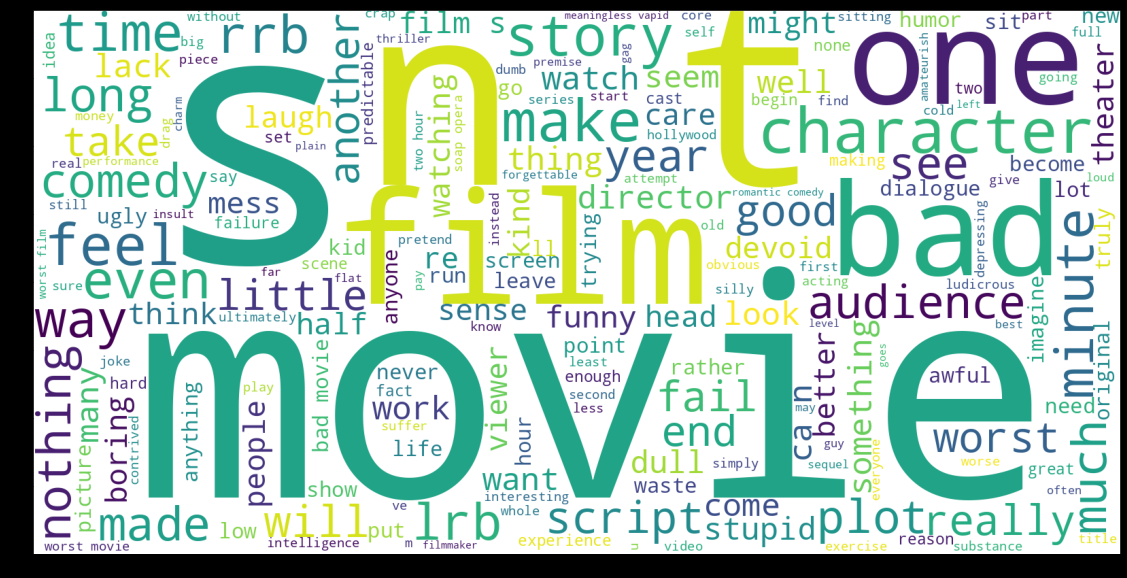

In [11]:
negative = data[data['Sentiment'] == 0]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(negative.Phrase))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

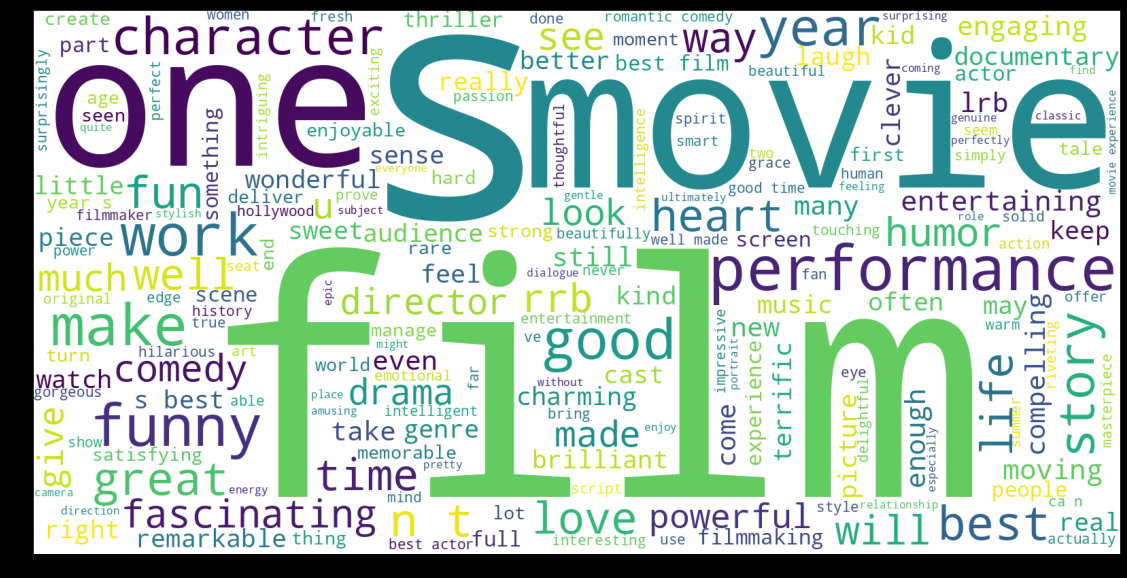

In [12]:
positive = data[data['Sentiment'] == 4]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(positive.Phrase))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

# Training with Machine Learning Algorithms

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
X_train = train_set.Phrase.values
Y_train = train_set.Sentiment.values
X_test = test_set.Phrase.values
Y_test = test_set.Sentiment.values
target_categories = ["0","1","2","3","4"]

## Naive Bayes Classifier

Naive Bayes Train Accuracy Score : 63% 
Naive Bayes Test Accuracy Score  : 59% 

              precision    recall  f1-score   support

           0       0.02      0.68      0.04        22
           1       0.24      0.51      0.32      1241
           2       0.91      0.60      0.73     11904
           3       0.38      0.54      0.44      2264
           4       0.04      0.62      0.08        65

    accuracy                           0.59     15496
   macro avg       0.32      0.59      0.32     15496
weighted avg       0.77      0.59      0.65     15496



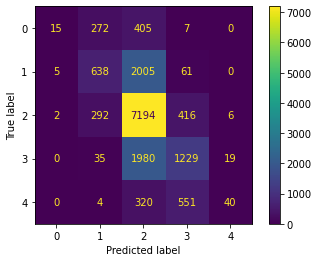

In [15]:
vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(X_train)
# print(X_test)

# Training the classifier with Naive Bayes
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, Y_train)
test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Support Vector Machine (SGD Classifier)

SVM Train Accuracy Score : 58% 
SVM Test Accuracy Score  : 56% 

              precision    recall  f1-score   support

           0       0.08      0.50      0.14       113
           1       0.11      0.49      0.17       582
           2       0.96      0.57      0.71     13287
           3       0.21      0.51      0.30      1328
           4       0.12      0.60      0.20       186

    accuracy                           0.56     15496
   macro avg       0.29      0.54      0.31     15496
weighted avg       0.84      0.56      0.65     15496



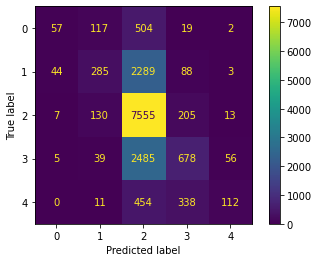

In [16]:
sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier()),
               ])

sgd.fit(X_train, Y_train)
test_predict = sgd.predict(X_test)

train_accuracy = round(sgd.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("SVM Train Accuracy Score : {}% ".format(train_accuracy))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Decision Tree Classifier

Decision Tree Train Accuracy Score : 95% 
Decision Tree Test Accuracy Score  : 58% 

              precision    recall  f1-score   support

           0       0.32      0.34      0.33       665
           1       0.42      0.47      0.44      2421
           2       0.77      0.69      0.72      8826
           3       0.41      0.47      0.43      2831
           4       0.33      0.41      0.37       753

    accuracy                           0.58     15496
   macro avg       0.45      0.47      0.46     15496
weighted avg       0.61      0.58      0.59     15496



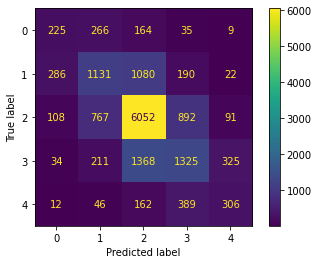

In [17]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)
test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## K-Nearest Neighbour Classifier

K-Nearest Neighbour Train Accuracy Score : 73% 
K-Nearest Neighbour Test Accuracy Score  : 62% 

              precision    recall  f1-score   support

           0       0.36      0.41      0.38       610
           1       0.47      0.50      0.49      2557
           2       0.81      0.68      0.74      9374
           3       0.43      0.56      0.49      2501
           4       0.27      0.54      0.36       454

    accuracy                           0.62     15496
   macro avg       0.47      0.54      0.49     15496
weighted avg       0.66      0.62      0.63     15496



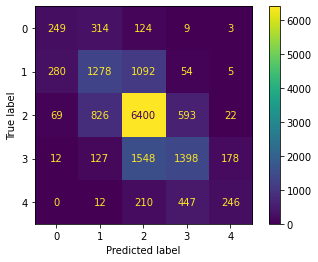

In [18]:
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
               ])

knn.fit(X_train, Y_train)
test_predict = knn.predict(X_test)

train_accuracy = round(knn.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Logistic Regression Classifier

Logistic Regression Train Accuracy Score : 66% 
Logistic Regression Test Accuracy Score  : 63% 

              precision    recall  f1-score   support

           0       0.13      0.60      0.21       149
           1       0.31      0.53      0.39      1588
           2       0.90      0.65      0.76     10915
           3       0.44      0.57      0.50      2546
           4       0.22      0.67      0.33       298

    accuracy                           0.63     15496
   macro avg       0.40      0.61      0.44     15496
weighted avg       0.75      0.63      0.66     15496



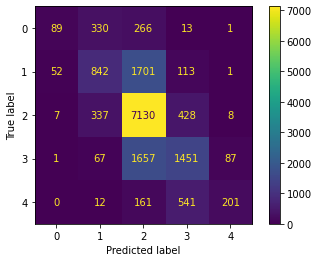

In [19]:
lr = Pipeline([('tfidf', TfidfVectorizer()),
                ('lr', LogisticRegression(random_state=42, solver='liblinear')),
               ])

lr.fit(X_train, Y_train)
test_predict = lr.predict(X_test)

train_accuracy = round(lr.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Logistic Regression Train Accuracy Score : {}% ".format(train_accuracy))
print("Logistic Regression Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

# Training with BERT

In [20]:
# Load Huggingface transformers
from transformers import TFBertModel, BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SpatialDropout1D, Conv1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import LAMB, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

## Get Pretrained BERT Model and Prepare Data with Tokenizer

In [21]:
# Name of the BERT model to use
model_name = 'bert-base-cased'

# Max length of tokens
length = len(data.Phrase)
dff = [len(i.split(" ")) for i in data.Phrase[:length]]
max_length = max(dff)+3

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [22]:
y_senti = to_categorical(data[data.data_type=='train'].Sentiment)

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='train'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

train = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
def map_func(input_ids, masks, labels):
    # convert three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

train = train.map(map_func)
batch_size = 32

# shuffle and batch - dropping any remaining samples that don't cleanly
train = train.shuffle(100).batch(batch_size, drop_remainder=True)

train.take(1)

<TakeDataset shapes: ({input_ids: (32, 51), attention_mask: (32, 51)}, (32, 5)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.float32)>

In [23]:
y_senti = to_categorical(data[data.data_type=='val'].Sentiment)

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='val'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

val = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
val = val.map(map_func)
val = val.shuffle(100).batch(batch_size, drop_remainder=True)

## Build the Model with Transfer Learning

In [24]:
# Build model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert = TFAutoModel.from_pretrained('bert-base-cased')
embeddings = bert.bert(inputs)[1]

# convert bert embeddings into 5 output classes
output = Flatten()(embeddings)
output = Dense(256, activation='relu')(output)
output = Dense(128, activation='relu')(output)

output = Dense(5, activation='softmax', name='outputs')(output)

model = Model(inputs=inputs, outputs=output)

# Take a look at the model
model.summary()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 51)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 51)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 768)          0           bert[0][1]                   

In [25]:
optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-6)
loss = CategoricalCrossentropy()
acc = CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

## Train the BERT Model with Train and Validation Data

In [26]:
# Fit the model
history = model.fit(
    train,
    validation_data=val,
    epochs=3)

Epoch 1/3


2021-12-28 15:16:06.412695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


3527/3527 [==============================] - 775s 216ms/step - loss: 0.8366 - accuracy: 0.6520 - val_loss: 0.7328 - val_accuracy: 0.6959
Epoch 2/3
3527/3527 [==============================] - 759s 215ms/step - loss: 0.7017 - accuracy: 0.7040 - val_loss: 0.7167 - val_accuracy: 0.7037
Epoch 3/3
3527/3527 [==============================] - 759s 215ms/step - loss: 0.6339 - accuracy: 0.7324 - val_loss: 0.7304 - val_accuracy: 0.6981


In [27]:
model.save_weights('./sentiment-analysis-on-movie-reviews/bert_weights.h5')

In [ ]:
model.load_weights('./sentiment-analysis-on-movie-reviews/bert_weights.h5')

## Plot Confusion Matrix for Test Data

In [29]:
def map_func(input_ids, masks):
    return {'input_ids': input_ids, 'attention_mask': masks}

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='test'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

test = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask']))
test = test.map(map_func)
test = test.batch(32)

In [30]:
y_test = data[data.data_type=='test'].Sentiment
y_pred = model.predict(test).argmax(axis=-1)

BERT Train Accuracy Score :      73% 
BERT Validation Accuracy Score : 70% 
BERT Test Accuracy Score  :      70% 

              precision    recall  f1-score   support

           0       0.53      0.42      0.47       699
           1       0.59      0.61      0.60      2709
           2       0.78      0.81      0.80      7910
           3       0.63      0.61      0.62      3263
           4       0.60      0.51      0.55       915

    accuracy                           0.70     15496
   macro avg       0.63      0.59      0.61     15496
weighted avg       0.69      0.70      0.70     15496



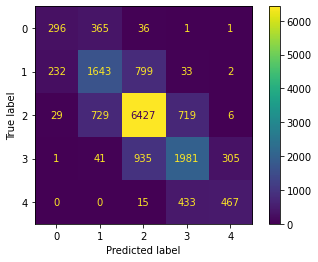

In [33]:
# Plot Confusion Matrix for Test Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

print("BERT Train Accuracy Score :      {:.0f}% ".format(history.history['accuracy'][-1]*100))
print("BERT Validation Accuracy Score : {:.0f}% ".format(history.history['val_accuracy'][-1]*100))
print("BERT Test Accuracy Score  :      {:.0f}% ".format(accuracy_score(y_test, y_pred)*100))
print()
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

# Get Classification Report for Validation Data
print(classification_report(y_test, y_pred, target_names=target_categories))